In [ ]:
import numpy as np
import matplotlib.pyplot as plt
try:
  import google.colab
except ImportError:
  from dolfin import *
else:
  try:
    from dolfin import *
  except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
%matplotlib inline

In [ ]:
# 1. Read the mesh for this problem
from google.colab import drive
drive.mount('/content/drive')

mesh = Mesh("/content/drive/My Drive/Colab Notebooks/mesh_data/mesh.xml")
subdomains = MeshFunction("size_t", mesh, "/content/drive/My Drive/Colab Notebooks/mesh_data/mesh_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "/content/drive/My Drive/Colab Notebooks/mesh_data/mesh_facet_region.xml")
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
ds_sym = ds(2) + ds(3) + ds(6)
ds_bottom = ds(1)
ds_sf = ds(5) + ds(7) + ds(8) + ds(9) + ds(10)
ds_top = ds(4) + ds(11) + ds(12) + ds(13) + ds(14)
ds_out = ds(15)
dx_cc1 = dx(1) 
dx_cc2 = dx(2)
dx_cc2_upper = dx(4)
dx_bb_surround = dx(3)
dx_cc = dx(6)
dx_cb = dx(5)
dx_ss = dx(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2A. Material properties
#Youngs modulus
E_cc1 = 9.89E9
E_cc2 = E_cc2_upper = 14.2E9
E_bb_surround = 14.4E9
E_cb = 58.1E9
E_ss = 200.0E9
E_cc = 1.75E9

#Poisson ratio
nu_cc1 = 0.3
nu_cc2 = nu_cc2_upper = 0.2
nu_bb_surround = 0.2
nu_cb = 0.08
nu_ss = 0.25
nu_cc = 0.13

#Lam\'e parameters
mu_cc1, lmbda_cc1 = Constant(E_cc1/(2.*(1.+nu_cc1))), Constant(E_cc1*nu_cc1/((1.+nu_cc1)*(1.-2.*nu_cc1)))
mu_cc2, lmbda_cc2 = Constant(E_cc2/(2.*(1.+nu_cc2))), Constant(E_cc2*nu_cc2/((1.+nu_cc2)*(1.-2.*nu_cc2)))
mu_cc2_upper, lmbda_cc2_upper = Constant(E_cc2_upper/(2.*(1.+nu_cc2_upper))), Constant(E_cc2_upper*nu_cc2_upper/((1.+nu_cc2_upper)*(1.-2.*nu_cc2_upper)))
mu_bb_surround, lmbda_bb_surround = Constant(E_bb_surround/(2.*(1.+nu_bb_surround))), Constant(E_bb_surround*nu_bb_surround/((1.+nu_bb_surround)*(1.-2.*nu_bb_surround)))
mu_cb, lmbda_cb = Constant(E_cb/(2.*(1.+nu_cb))), Constant(E_cb*nu_cb/((1.+nu_cb)*(1.-2.*nu_cb)))
mu_ss, lmbda_ss = Constant(E_ss/(2.*(1.+nu_ss))), Constant(E_ss*nu_ss/((1.+nu_ss)*(1.-2.*nu_ss)))
mu_cc, lmbda_cc = Constant(E_cc/(2.*(1.+nu_cc))), Constant(E_cc*nu_cc/((1.+nu_cc)*(1.-2.*nu_cc)))

#Material densities
rho_cc1 = 1. #3520.0
rho_cc2 = rho_cc2_upper = 1. #3200.0
rho_bb_surround = 1. #2800.0
rho_cb = 1. #1760.0
rho_ss = 1. #7900.0
rho_cc = 1. #2080.0

# 2B. Rayleigh damping coefficient
eta_m = Constant(0.0)
eta_k = Constant(0.0)

# 2C. Generalised alpha method parameters
alpha_m = Constant(0.)
alpha_f = Constant(0.)
gamma = Constant(0.5 + alpha_f - alpha_m)
beta = Constant((gamma+0.5)**2/4.)

In [ ]:
# 3A. Function spaces
VM = VectorFunctionSpace(mesh,"CG",1)
VMsig = TensorFunctionSpace(mesh,"DG",0)
u_, phi = TrialFunction(VM), TestFunction(VM)
u = Function(VM,name="Displacement")
u_old = Function(VM)
v_old = Function(VM)
a_old = Function(VM)

x0 = Expression("x[0]",element=VM.sub(0).ufl_element())
x1 = Expression("x[1]",element=VM.sub(1).ufl_element())

# 3B. # Boundary condition
bcs = [DirichletBC(VM.sub(1), Constant(0.), boundaries, 1), DirichletBC(VM.sub(0), Constant(0.), boundaries, 2), DirichletBC(VM.sub(0), Constant(0.), boundaries, 3), \
       DirichletBC(VM.sub(0), Constant(0.), boundaries, 6), DirichletBC(VM.sub(1), Constant(0.), boundaries, 4), DirichletBC(VM.sub(1), Constant(0.), boundaries, 11), \
			 DirichletBC(VM.sub(1), Constant(0.), boundaries, 12), DirichletBC(VM.sub(1), Constant(0.), boundaries, 13), DirichletBC(VM.sub(1), Constant(0.), boundaries, 14)]

In [ ]:
# 4A.  Time steps
T = 40.
Nsteps = 100
dt = Constant(T/Nsteps)

# 3B. Source term/ Extenal force
n = FacetNormal(mesh)
rho_liquid = 7874.
H = max(mesh.coordinates()[:,1])
p = Expression("x[1] <= t*H/T ? rho * g * (t*H/T-x[1]) : 0", t=0, H = H, T = T, rho=rho_liquid, g = 9.81, degree=1)

In [ ]:
# 5A. Stress tensor
def sigma_cc1(r):
	return 2.*mu_cc1*sym(grad(r)) + lmbda_cc1*tr(sym(grad(r)))*Identity(len(r))
def sigma_cc2(r):
	return 2.*mu_cc2*sym(grad(r)) + lmbda_cc2*tr(sym(grad(r)))*Identity(len(r))
def sigma_cc2_upper(r):
	return 2.*mu_cc2_upper*sym(grad(r)) + lmbda_cc2_upper*tr(sym(grad(r)))*Identity(len(r))
def sigma_bb_surround(r):
	return 2.*mu_bb_surround*sym(grad(r)) + lmbda_bb_surround*tr(sym(grad(r)))*Identity(len(r))
def sigma_cb(r):
	return 2.*mu_cb*sym(grad(r)) + lmbda_cb*tr(sym(grad(r)))*Identity(len(r))
def sigma_ss(r):
	return 2.*mu_ss*sym(grad(r)) + lmbda_ss*tr(sym(grad(r)))*Identity(len(r))
def sigma_cc(r):
	return 2.*mu_cc*sym(grad(r)) + lmbda_cc*tr(sym(grad(r)))*Identity(len(r))

# 5B. Mass matrix
def m(u_,phi):
	return rho_cc1 * inner(u_,phi) * dx_cc1 + rho_cc2 * inner(u_,phi) * dx_cc2 + rho_bb_surround * inner(u_,phi) * dx_bb_surround + rho_cc2_upper * inner(u_,phi) * dx_cc2_upper \
	+ rho_cb * inner(u_,phi) * dx_cb + rho_ss * inner(u_,phi) * dx_ss + rho_cc * inner(u_,phi) * dx_cc

# 5C. Stiffnss matrix
def k(u_,phi):
	return inner(sigma_cc1(u_),sym(grad(phi))) * dx_cc1 + inner(sigma_cc2(u_),sym(grad(phi))) * dx_cc2 + inner(sigma_cc2_upper(u_),sym(grad(phi))) * dx_cc2_upper + \
	inner(sigma_bb_surround(u_),sym(grad(phi))) * dx_bb_surround + inner(sigma_cb(u_),sym(grad(phi))) * dx_cb + inner(sigma_ss(u_),sym(grad(phi))) * dx_ss + \
	inner(sigma_cc(u_),sym(grad(phi))) * dx_cc

# 5D. Damping matrix
def c(u_,phi):
	return eta_m*m(u_,phi) + eta_k*k(u_,phi)

# 5E. Work of external forces
def Wext(phi,p):
	return dot(phi,p*n) * ds_sf

def update_a(u,u_old,v_old,a_old,ufl=True):
	if ufl:
		dt_ = dt
		beta_ = beta
	else:
		dt_ = float(dt)
		beta_ = float(beta)
	return (u - u_old - dt*v_old)/(beta * dt**2) - (1 - 2*beta) * a_old /(2*beta)

def update_v(a,u_old,v_old,a_old,ufl=True):
	if ufl:
		dt_ = dt
		gamma_ = gamma
	else:
		dt_ = float(dt)
		gamma_ = float(gamma)
	return v_old + dt_ * ((1-gamma_) * a_old + gamma_ * a)

def update_fields(u,u_old,v_old,a_old):
	#Store reference
	u_vec, u0_vec = u.vector(), u_old.vector()
	v0_vec, a0_vec = v_old.vector(), a_old.vector()
	# Updated velocity and accelaration
	a_current = update_a(u_vec,u0_vec,v0_vec,a0_vec,ufl=False)
	v_current = update_v(a_current,u0_vec,v0_vec,a0_vec,ufl=False)
	#Update v_old and a_old
	a_old.vector()[:] = a_current
	v_old.vector()[:] = v_current
	u_old.vector()[:] = u.vector().get_local()

def avg(x_old,x_new,alpha):
	return (1-alpha) * x_new + alpha * x_old

In [ ]:
# Residual forms
a_new = update_a(u_, u_old, v_old, a_old, ufl=True)
v_new = update_v(a_new, u_old, v_old, a_old, ufl=True)
res_total = m(avg(a_old,a_new,alpha_m),phi) + c(avg(v_old,v_new,alpha_f),phi) + k(avg(u_old,u_,alpha_f),phi) - Wext(phi,p)
a_form = lhs(res_total)
L_form = rhs(res_total)
K, res = assemble_system(a_form, L_form, bcs)
solver = LUSolver(K,"mumps")
solver.parameters["symmetric"] = True

# Time-stepping
num_subdomains = 7
time = np.linspace(0,T,Nsteps+1)
u_max_x = np.zeros((Nsteps+1,num_subdomains))
u_min_x = np.zeros((Nsteps+1,num_subdomains))
u_max_y = np.zeros((Nsteps+1,num_subdomains))
u_min_y = np.zeros((Nsteps+1,num_subdomains))
von_mises_max = np.zeros((Nsteps+1,num_subdomains))
energies = np.zeros((Nsteps+1,4))
E_damp = 0
E_ext = 0
sig = Function(VMsig,name="sigma")
xdmf_file = XDMFFile("/content/drive/My Drive/Colab Notebooks/solution_field/elastodynamics_results.xdmf")
xdmf_file.parameters["flush_output"] = True
xdmf_file.parameters["functions_share_mesh"] = True
xdmf_file.parameters["rewrite_function_mesh"] = False

# For stress computation
def local_project(u_sol,VMsig,sigma_sol=None):
	sigma_trial = TrialFunction(VMsig)
	sigma_test = TestFunction(VMsig)
	a_proj = inner(sigma_trial,sigma_test) * dx
	b_proj = inner(sigma_cc1(u_sol),sigma_test) * dx_cc1 + inner(sigma_cc2(u_sol),sigma_test) * dx_cc2 + inner(sigma_bb_surround(u_sol),sigma_test) * dx_bb_surround + \
	inner(sigma_cc2_upper(u_sol),sigma_test) * dx_cc2_upper + inner(sigma_cb(u_sol),sigma_test) * dx_cb + inner(sigma_ss(u_sol),sigma_test) * dx_ss + inner(sigma_cc(u_sol),sigma_test) * dx_cc
	solver = LocalSolver(a_proj,b_proj)
	solver.factorize()
	if sigma_sol is None:
		sigma_sol = Function(VMsig)
		solver.solve_local_rhs(sigma_sol)
		return sigma_sol
	else:
		solver.solve_local_rhs(sigma_sol)
		return

def subdomainwise_displacement_stress(u_sol,VM,sigma_funcs,num_subdomains,volume_measures):
	max_min_displacement_max_stress = np.zeros([5,num_subdomains]) #u_max_x,u_min_x,u_max_y,u_min_y,sigma_von_mises
	u_sol_subdomain = Function(VM)
	u = TrialFunction(VM)
	v = TestFunction(VM)
	if VM.ufl_element().degree() == 1:
		VM_von_mises = FunctionSpace(mesh, 'DG', 0)
	else:
		VM_von_mises = FunctionSpace(mesh, 'CG', VM.ufl_element().degree() - 1)
	aM = inner(u,v)*dx
	for i in range(num_subdomains):
		bM = inner(u_sol,v) * volume_measures[i]
		solve(aM==bM,u_sol_subdomain)
		s = sigma_funcs[i](u_sol_subdomain) - (1./3.)*tr(sigma_funcs[i](u_sol_subdomain))*Identity(2)
		von_Mises = sqrt(3./2.*inner(s, s))
		von_Mises = project(von_Mises, VM_von_mises)
		max_min_displacement_max_stress[0,i] = max(u_sol.sub(0).vector().get_local())
		max_min_displacement_max_stress[1,i] = min(u_sol.sub(0).vector().get_local())
		max_min_displacement_max_stress[2,i] = min(u_sol.sub(1).vector().get_local())
		max_min_displacement_max_stress[3,i] = min(u_sol.sub(1).vector().get_local())
		max_min_displacement_max_stress[4,i] = max(von_Mises.vector().get_local())
	return max_min_displacement_max_stress

for (i,dt) in enumerate(np.diff(time)):
	t = time[i+1]
	print("Time: ",t)
	
	p.t = t - float(alpha_f*dt)
	p_old = p

	res = assemble(L_form)
	bcs[0].apply(res)
	solver.solve(K, u.vector(), res)
	
	update_fields(u, u_old, v_old, a_old)
	ALE.move(mesh,u)
	xdmf_file.write(u,t)
	ALE.move(mesh,project(-u,VM))
	
	local_project(u,VMsig,sig)
	xdmf_file.write(sig, t)

	p.t = t
	
	displacement_stress_results = subdomainwise_displacement_stress(u, VM, [sigma_cc1,sigma_cc2,sigma_bb_surround,sigma_cc2_upper,sigma_cb,sigma_ss,sigma_cc], 7, \
	                                                                [dx_cc1,dx_cc2,dx_bb_surround,dx_cc2_upper,dx_cb,dx_ss,dx_cc])
	u_max_x[i+1,:], u_min_x[i+1,:], u_max_y[i+1,:], u_min_y[i+1,:], von_mises_max[i+1,:] = displacement_stress_results[0,:], displacement_stress_results[1,:], displacement_stress_results[2,:], displacement_stress_results[3,:], displacement_stress_results[4,:]
	
	E_elas = assemble(0.5*k(u_old,u_old))
	E_kin = assemble(0.5*m(v_old,v_old))
	E_damp += dt*assemble(c(v_old,v_old)) #TODO: check
	#E_ext = assemble(Wext(u_old,p_old)) # TODO
	E_tot = E_elas + E_kin + E_damp #- E_ext
	print("E_elas",E_elas)
	print("E_kin",E_kin)
	print("E_damp",E_damp)
	print("E_tot",E_tot)
	energies[i+1,:] = np.array([E_elas,E_kin,E_damp,E_tot])

Time:  0.4
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  0.8
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  1.2000000000000002
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  1.6
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  2.0
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  2.4000000000000004
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  2.8000000000000003
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  3.2
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  3.6
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  4.0
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  4.4
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  4.800000000000001
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  5.2
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  5.6000000000000005
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  6.0
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  6.4
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  6.800000000000001
E_elas 0.0
E_kin 0.0
E_damp 0.0
E_tot 0.0
Time:  7.2


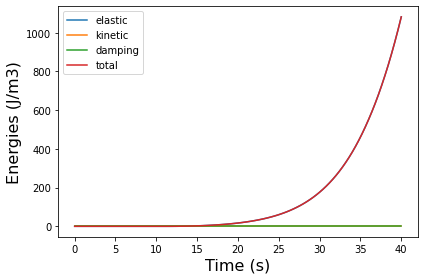

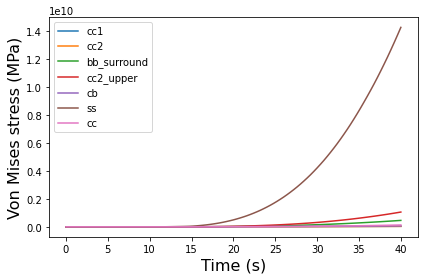

In [ ]:
# Plot energies evolution
fig = plt.figure()
plt.plot(time, energies)
plt.legend(("elastic", "kinetic", "damping", "total"),loc="upper left")
plt.xlabel("Time (s)",fontsize=16)
plt.ylabel("Energies (J/m3)",fontsize=16)
plt.tight_layout()
#plt.show()
fig.savefig("energies.png")

# Plot Von Mises stress
fig = plt.figure()
for i in range(num_subdomains):
  plt.plot(time,von_mises_max[:,i])
plt.legend(("cc1","cc2","bb_surround","cc2_upper","cb","ss","cc"),loc="upper left")
plt.xlabel("Time (s)",fontsize=16)
plt.ylabel("Von Mises stress (MPa)",fontsize=16)
plt.tight_layout()
#plt.show()
fig.savefig("von_mises_stress.png")